In [1]:
"""
Import Statements
"""

import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
from geopy import distance
import math
from matplotlib.patches import Ellipse

In [2]:
"""
Reading in CSV File
"""

data = pd.read_csv('metro-bike-share-trip-data.csv', parse_dates = ['Start Time', 'End Time'], infer_datetime_format = True)

/home/sachk/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
"Visualizing what we are dealing with"
data.head()

,Trip ID,Duration,Start Time,End Time,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Ending Station ID,Ending Station Latitude,Ending Station Longitude,Bike ID,Plan Duration,Trip Route Category,Passholder Type,Starting Lat-Long,Ending Lat-Long
0,1912818,180,2016-07-07 04:17:00,2016-07-07 04:20:00,3014.0,34.056610,-118.23721,3014.0,34.056610,-118.23721,6281.0,30.0,Round Trip,Monthly Pass,"{'longitude': '-118.23721', 'latitude': '34.05...","{'longitude': '-118.23721', 'latitude': '34.05..."
1,1919661,1980,2016-07-07 06:00:00,2016-07-07 06:33:00,3014.0,34.056610,-118.23721,3014.0,34.056610,-118.23721,6281.0,30.0,Round Trip,Monthly Pass,"{'longitude': '-118.23721', 'latitude': '34.05...","{'longitude': '-118.23721', 'latitude': '34.05..."
2,1933383,300,2016-07-07 10:32:00,2016-07-07 10:37:00,3016.0,34.052898,-118.24156,3016.0,34.052898,-118.24156,5861.0,365.0,Round Trip,Flex Pass,"{'longitude': '-118.24156', 'latitude': '34.05...","{'longitude': '-118.24156', 'latitude': '34.05..."
3,1944197,10860,2016-07-07 10:37:00,2016-07-07 13:38:00,3016.0,34.052898,-118.24156,3016.0,34.052898,-118.24156,5861.0,365.0,Round Trip,Flex Pass,"{'longitude': '-118.24156', 'latitude': '34.05...","{'longitude': '-118.24156', 'latitude': '34.05..."
4,1940317,420,2016-07-07 12:51:00,2016-07-07 12:58:00,3032.0,34.049889,-118.25588,3032.0,34.049889,-118.25588,6674.0,0.0,Round Trip,Walk-up,"{'longitude': '-118.25588', 'latitude': '34.04...","{'longitude': '-118.25588', 'latitude': '34.04..."


In [4]:
"""
Establishing any relation between Plan Duration, which is either 0, 30, 365, and Trip Route Category, which is either oneway
or roundtrip.

For the pivot_tables, the index represents the rows, columns represents columns, values is the specific column of data, which
we will be summing to get a count for a specific index and column

"""

data.pivot_table(index = 'Plan Duration', columns = 'Trip Route Category', values = 'Trip ID', aggfunc = 'count')

Trip Route Category,One Way,Round Trip
Plan Duration,,
0.0,32777,8447
30.0,77215,3705
365.0,9034,483


In [5]:
#Establish that there are four different Pass Types
data['Passholder Type'].unique()

array(['Monthly Pass', 'Flex Pass', 'Walk-up', 'Staff Annual'],
      dtype=object)

In [6]:
"""
Create helpful columns in the data matrix that take information from date, such as the day (range = 0-6) or hour (range = 0-23), etc.

"""

data['date'] = pd.DatetimeIndex(data['Start Time']).date.astype('datetime64')
data['hour'] = pd.DatetimeIndex(data['Start Time']).hour
data['day'] = pd.DatetimeIndex(data['Start Time']).dayofweek
data['month'] = pd.DatetimeIndex(data['Start Time']).month
data['season']  = pd.DatetimeIndex(data['Start Time']).month

In [7]:
"""
Spring runs from March 1 to May 31;
Summer runs from June 1 to August 31;
Fall (autumn) runs from September 1 to November 30; and
Winter runs from December 1 to February 28 (February 29 in a leap year).

Source for Commute Leave: http://overflow.solutions/demographic-data/what-time-does-the-average-american-leave-for-work/
"""

'\nSpring runs from March 1 to May 31;\nSummer runs from June 1 to August 31;\nFall (autumn) runs from September 1 to November 30; and\nWinter runs from December 1 to February 28 (February 29 in a leap year).\n\nSource for Commute Leave: http://overflow.solutions/demographic-data/what-time-does-the-average-american-leave-for-work/\n'

In [8]:
"""
Right now, season is a boolean value, but to convert it to a string, a series of comparisons are made, based on monthly information
I found online
"""

data['season'].loc[data['month'] >= 1] = 'winter'
data['season'].loc[data['month'] >= 3] = 'spring'
data['season'].loc[data['month'] >= 5] = 'summer'
data['season'].loc[data['month'] >= 10] = 'fall'
data['season'].loc[data['month'] >= 12] = 'winter'

/home/sachk/.local/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
#Get the frequency of each season

data['season'].value_counts()

summer    55439
fall      32589
winter    30493
spring    13906
Name: season, dtype: int64

In [10]:
#Generate a pivot table whose index is date, to visualize 

by_date = data.pivot_table(index = 'date', values = 'Trip ID', aggfunc = 'count', columns = 'Passholder Type').fillna(0)
by_date.head()

Passholder Type,Flex Pass,Monthly Pass,Staff Annual,Walk-up
date,,,,
2016-07-07,61.0,128.0,0.0,1.0
2016-07-08,93.0,251.0,0.0,1.0
2016-07-09,113.0,308.0,0.0,0.0
2016-07-10,75.0,259.0,0.0,0.0
2016-07-11,55.0,295.0,0.0,0.0


In [11]:
#Count Table of date's vs Plan Durations (Either 0, 30, or 365 (Walkup, Monthly, or Annual))

nby_date = data.pivot_table(index = 'date', values = 'Trip ID', aggfunc = 'count', columns = 'Plan Duration').fillna(0)
nby_date.head()

Plan Duration,0.0,30.0,365.0
date,,,
2016-07-07,1.0,128.0,61.0
2016-07-08,1.0,251.0,93.0
2016-07-09,0.0,308.0,113.0
2016-07-10,0.0,259.0,75.0
2016-07-11,0.0,295.0,55.0


In [12]:
nby_date.columns = ['Walk-Up', 'Monthly', 'Annual(Flex)']

In [14]:
#Dates with maximum value

nby_date.idxmax()

Walk-Up        2016-10-16
Monthly        2016-08-04
Annual(Flex)   2016-07-09
dtype: datetime64[ns]

In [15]:
nby_date['Walk-Up']['2016-10-16']

1003.0

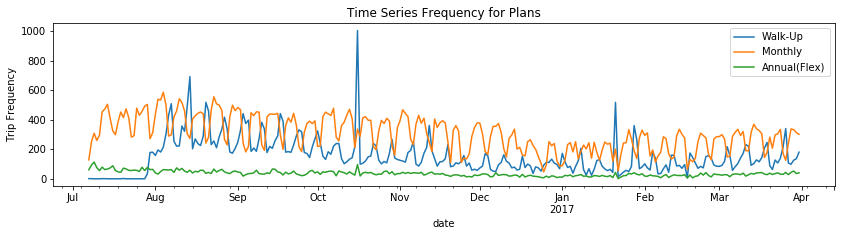

In [16]:
"""
Plot of Trip per Plan Usage over time
"""

fig, ax = plt.subplots(1, figsize = (14, 3))
ax.set_ylabel("Trip Frequency")
fig.subplots_adjust(hspace=0.7)
nby_date.iloc[:].plot(ax=ax, title = 'Time Series Frequency for Plans')

In [17]:
df=data.dropna(subset=['Starting Station Latitude', 'Starting Station Longitude', 'Ending Station Latitude', 'Ending Station Longitude'])

In [18]:
def weighted_avg_and_std(values, weights):
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

0.004737307887552592 0.010021147895684878


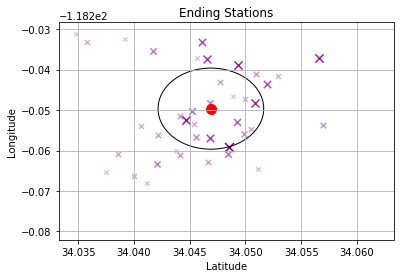

In [19]:
pivoter = df.pivot_table(index = 'Ending Station ID', values = 'Trip ID', aggfunc = 'count').sort_values(by = 'Trip ID', ascending = False).iloc[0:40]
pivoter2 = df.pivot_table(index = 'Starting Station ID', values = 'Trip ID', aggfunc = 'count').sort_values(by = 'Trip ID', ascending = False).iloc[0:40]


"""
pivoter is a sorted list of the highest frequency ending stations
pivoter2 is a sorted list of the highest frequency station stations

This plot shows the highest frequency end stations, with their ID's converted to lat,long coordinates
"""
count = 0
lat_long = np.zeros(shape=(len(pivoter.index), 3))
for i in pivoter.index:
    try:
        rez = data.iloc[np.where(data['Ending Station ID'] == i)].iloc[-1]
        plt.scatter(rez['Ending Station Latitude'], rez['Ending Station Longitude'],
                    alpha = pivoter.loc[i]/pivoter.max(), color = 'purple', marker = 'x', s = 80*pivoter.loc[i]/pivoter.max())
        lat_long[count][0] = rez['Ending Station Latitude']
        lat_long[count][1] = rez['Ending Station Longitude']
        lat_long[count][2] = pivoter.loc[i]/pivoter.max()
        count +=1
    except:
        pass

lat_long[:,0].mean()
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Ending Stations')
plt.grid()
mean_x, var_x = weighted_avg_and_std(lat_long[:,0], lat_long[:,2])
mean_y, var_y = weighted_avg_and_std(lat_long[:,1], lat_long[:,2])

print(var_x, var_y)
plt.scatter(mean_x,mean_y , color = 'red', s = 100)
ax = plt.gca()
ax.add_patch(Ellipse( (mean_x, mean_y), 2*var_x, 2*var_y, fill = False))
largest = data.iloc[np.where(data['Ending Station ID'] == pivoter.iloc[0].name)].iloc[0]

0.0052797967270046126 0.009096701756193308


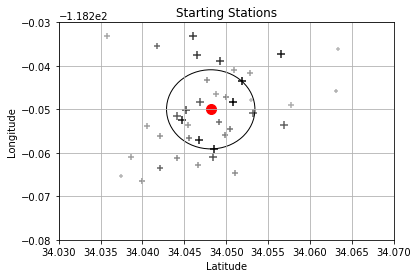

In [20]:
"""
This is a similar plot to the above, but is a plot of Starting Station ID's
"""

count = 0
lat_long = np.zeros(shape=(len(pivoter2.index), 3))
for i in pivoter2.index:
    try:
        rez = data.iloc[np.where(data['Starting Station ID'] == i)].iloc[-1]
        plt.scatter(rez['Starting Station Latitude'], rez['Starting Station Longitude'],
                    alpha = pivoter2.loc[i]/pivoter2.max(), color = 'black', marker = '+', s = 80*pivoter2.loc[i]/pivoter2.max())
        lat_long[count][0] = rez['Starting Station Latitude']
        lat_long[count][1] = rez['Starting Station Longitude']
        lat_long[count][2] = pivoter2.loc[i]/pivoter2.max()
        count +=1
    except:
        pass

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Starting Stations')
plt.grid()
plt.xlim(34.03, 34.07)
plt.ylim(-118.28,-118.23)
mean_x, var_x = weighted_avg_and_std(lat_long[:,0], lat_long[:,2])
mean_y, var_y = weighted_avg_and_std(lat_long[:,1], lat_long[:,2])

print(var_x, var_y)
plt.scatter(mean_x,mean_y , color = 'red', s = 100)
ax = plt.gca()
ax.add_patch(Ellipse( (mean_x, mean_y), 2*var_x, 2*var_y, fill = False))

largest = data.iloc[np.where(data['Starting Station ID'] == pivoter.iloc[0].name)].iloc[0]

In [21]:
"""
This prints a list of stations who function as the highest start AND end trips
"""

new = []
all_done = set()
for i in pivoter2.index.values:
    #Adds indexes to new which are part of pivoter2
    if(i in pivoter.index.values):
        all_done.add(i)
        new.append([i, pivoter2.loc[i].values[0] + pivoter.loc[i].values[0]])
    else:
        new.append([i, 0])
        
for i in pivoter.index.values:
    #if not already added to new and part of pivoter
    if(i in pivoter2.index.values and i not in all_done):
        all_done.add(i)
        new.append([i, pivoter2.loc[i].values[0] + pivoter.loc[i].values[0]])
        
sorted(new, key = lambda x: x[1], reverse = True)

[[3005.0, 11113],
 [3069.0, 10164],
 [3031.0, 10111],
 [3014.0, 9929],
 [3042.0, 9274],
 [3030.0, 9260],
 [3064.0, 9219],
 [3082.0, 8560],
 [3022.0, 8194],
 [3067.0, 7256],
 [3035.0, 6906],
 [3063.0, 6683],
 [3038.0, 6476],
 [3048.0, 6131],
 [3034.0, 6052],
 [3055.0, 5703],
 [3049.0, 5623],
 [3006.0, 5504],
 [3032.0, 5229],
 [3007.0, 4758],
 [3074.0, 4688],
 [3062.0, 4475],
 [3023.0, 4459],
 [3027.0, 4402],
 [3075.0, 4388],
 [3008.0, 4378],
 [3047.0, 4197],
 [3019.0, 4073],
 [3051.0, 3976],
 [3076.0, 3849],
 [3016.0, 3846],
 [3058.0, 3726],
 [3052.0, 3725],
 [3029.0, 3289],
 [3056.0, 2937],
 [3068.0, 0],
 [3024.0, 0],
 [3026.0, 0],
 [3066.0, 0],
 [3046.0, 0]]

In [25]:
#Group data by the year, days of the week, and count based on the PLan Duration

weeks = nby_date.groupby([by_date.index.year, by_date.index.dayofweek]).mean()
weeks
#weeks.columns = ['None', 'Monthly', 'Annual']

Walk-Up     Monthly  Annual(Flex)
date date                                      
2016 0     134.520000  345.720000     34.080000
     1     124.320000  406.640000     38.600000
     2     125.320000  407.640000     44.160000
     3     142.423077  395.500000     45.576923
     4     174.076923  368.461538     42.538462
     5     245.769231  233.115385     39.384615
     6     260.560000  214.920000     39.560000
2017 0      78.692308  228.000000     24.692308
     1      71.076923  271.538462     25.153846
     2      88.846154  287.923077     27.692308
     3      84.692308  275.538462     27.230769
     4      99.153846  236.923077     26.461538
     5     222.000000  165.166667     26.750000
     6     179.307692  134.000000     20.384615

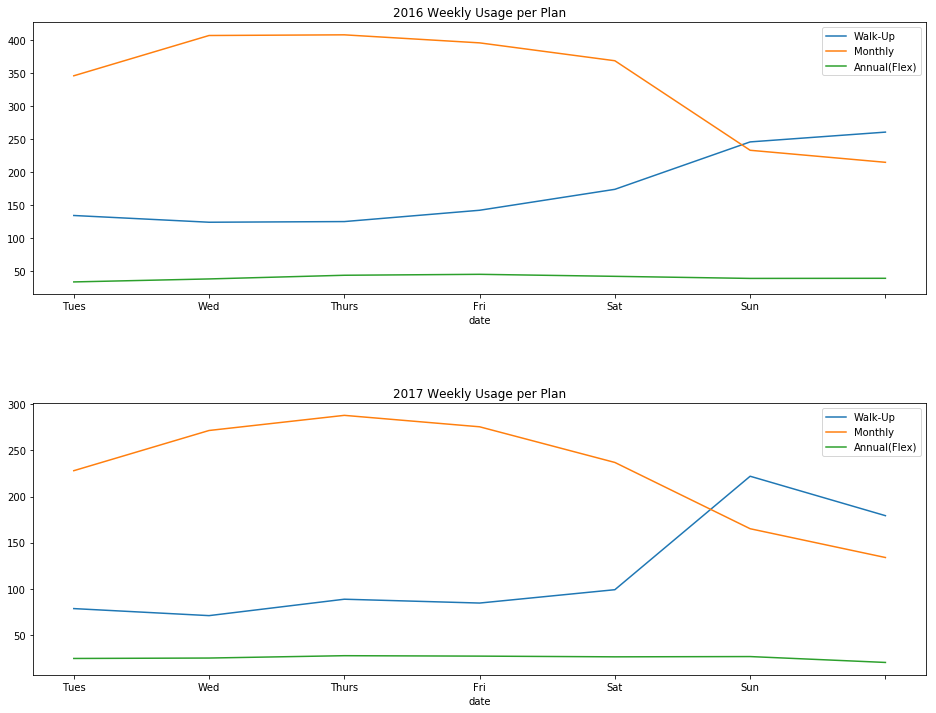

In [60]:
#Plotting weekly usage of bikes per plan for 2016 and 2017

fig, ax = plt.subplots(2, figsize = (16, 12))
fig.subplots_adjust(hspace=0.4)
for axs in ax:
    axs.set(xlabel = 'Day of the Week')
    axs.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
weeks.loc[2016].plot(ax = ax[0], title = '2016 Weekly Usage per Plan')
weeks.loc[2017].plot(ax = ax[1], title = '2017 Weekly Usage per Plan')

In [27]:
#Group data by date, where the columns are the hour in the day, and pLan duration

hourly_stats = data.pivot_table(index = ['date', 'hour'], values = 'Trip ID', aggfunc = 'count', columns = 'Plan Duration').fillna(0).reset_index('hour')
hourly_stats

Plan Duration,hour,0.0,30.0,365.0
date,,,,
2016-07-07,4,0.0,1.0,0.0
2016-07-07,6,0.0,1.0,0.0
2016-07-07,10,0.0,0.0,2.0
2016-07-07,12,1.0,2.0,1.0
2016-07-07,13,0.0,26.0,12.0
2016-07-07,14,0.0,13.0,6.0
2016-07-07,15,0.0,5.0,4.0
2016-07-07,16,0.0,8.0,8.0
2016-07-07,17,0.0,10.0,4.0


In [28]:
#I want to split the data into whether weekdays, and weekdays, and then get the counts per hour for each plan

hourly_stats['weekend'] = (hourly_stats.index.get_level_values('date').dayofweek >= 5)
weekend_split = hourly_stats.groupby(['weekend', 'hour']).mean()
weekend_split

Plan Duration      0.0        30.0      365.0
weekend hour                                 
False   0       2.382857   2.457143  0.342857
        1       1.595238   1.910714  0.196429
        2       1.050314   1.905660  0.088050
        3       0.427481   1.396947  0.045802
        4       0.238994   1.698113  0.037736
        5       0.380117   2.292398  0.070175
        6       0.946524   7.053476  0.358289
        7       1.842932  19.853403  0.869110
        8       3.041885  26.732984  2.172775
        9       3.700000  18.989474  2.378947
        10      4.486911  12.130890  1.486911
        11      6.821990  17.455497  2.497382
        12     10.291667  24.276042  2.557292
        13      9.781250  21.989583  2.833333
        14      9.161458  17.328125  2.083333
        15      8.723958  17.161458  1.864583
        16      8.135417  26.197917  2.052083
        17      9.630208  34.838542  3.203125
        18      8.416667  30.984375  3.453125
        19      7.826316  21.510526  2.584211
        20      6.706806  14.900524  2.036649
        21      6.962766  10.351064  1.515957
        22      5.984211   6.900000  1.052632
        23      4.296296   5.417989  0.507937
True    0       7.157895   3.723684  0.578947
        1       5.840000   3.266667  0.520000
        2       3.623188   1.724638  0.246377
        3       0.970149   1.925373  0.104478
        4       0.820000   1.240000  0.040000
        5       1.128205   1.128205  0.128205
        6       1.210526   1.649123  0.228070
        7       1.859155   3.253521  0.507042
        8       3.853333   5.053333  0.906667
        9       9.052632   8.552632  1.907895
        10     11.342105  11.578947  2.381579
        11     16.223684  13.342105  3.026316
        12     19.315789  15.144737  3.026316
        13     21.592105  15.934211  2.802632
        14     20.500000  15.184211  3.026316
        15     20.533333  15.986667  3.013333
        16     20.552632  15.894737  2.328947
        17     16.078947  14.947368  2.118421
        18     13.407895  13.263158  1.921053
        19     10.960526  11.605263  1.776316
        20      7.973333   9.880000  1.506667
        21      9.131579   7.144737  1.092105
        22      8.671053   5.828947  0.881579
        23      6.000000   4.693333  0.413333

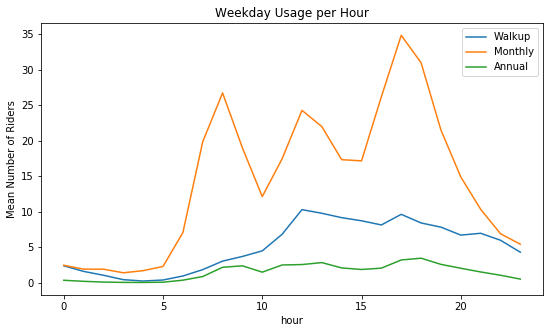

In [29]:
fig, ax = plt.subplots(1, figsize = (9, 5))
fig.subplots_adjust(wspace=0.4)
ax.set_ylabel('Mean Number of Riders')
#ax[1].set_ylabel('Mean Number of Riders')

weekend_split.loc[False].plot(ax=ax, title='Weekday Usage per Hour')
#weekend_split.loc[True].plot(ax=ax[1], title='Weekend Usage per Hour')

ax.legend(['Walkup', 'Monthly', 'Annual'])
#ax[1].legend(['Walkup', 'Monthly', 'Annual'])

In [30]:
data['weekend'] = data['day'] >= 5

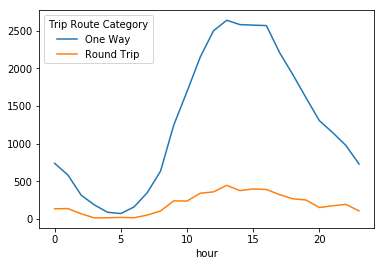

In [31]:
#Plot of the distribution of trip frequency over hours of the day for different trip routes

data.pivot_table(index = 'Trip Route Category', columns = ['weekend', 'hour'], values = 'Trip ID', aggfunc = 'count')[True].T.plot()

In [32]:
#Adding a minutes column to the main dataframe

data['minutes'] = data['Duration']/60
data.head()

,Trip ID,Duration,Start Time,End Time,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Ending Station ID,Ending Station Latitude,Ending Station Longitude,...,Passholder Type,Starting Lat-Long,Ending Lat-Long,date,hour,day,month,season,weekend,minutes
0,1912818,180,2016-07-07 04:17:00,2016-07-07 04:20:00,3014.0,34.056610,-118.23721,3014.0,34.056610,-118.23721,...,Monthly Pass,"{'longitude': '-118.23721', 'latitude': '34.05...","{'longitude': '-118.23721', 'latitude': '34.05...",2016-07-07,4,3,7,summer,False,3.0
1,1919661,1980,2016-07-07 06:00:00,2016-07-07 06:33:00,3014.0,34.056610,-118.23721,3014.0,34.056610,-118.23721,...,Monthly Pass,"{'longitude': '-118.23721', 'latitude': '34.05...","{'longitude': '-118.23721', 'latitude': '34.05...",2016-07-07,6,3,7,summer,False,33.0
2,1933383,300,2016-07-07 10:32:00,2016-07-07 10:37:00,3016.0,34.052898,-118.24156,3016.0,34.052898,-118.24156,...,Flex Pass,"{'longitude': '-118.24156', 'latitude': '34.05...","{'longitude': '-118.24156', 'latitude': '34.05...",2016-07-07,10,3,7,summer,False,5.0
3,1944197,10860,2016-07-07 10:37:00,2016-07-07 13:38:00,3016.0,34.052898,-118.24156,3016.0,34.052898,-118.24156,...,Flex Pass,"{'longitude': '-118.24156', 'latitude': '34.05...","{'longitude': '-118.24156', 'latitude': '34.05...",2016-07-07,10,3,7,summer,False,181.0
4,1940317,420,2016-07-07 12:51:00,2016-07-07 12:58:00,3032.0,34.049889,-118.25588,3032.0,34.049889,-118.25588,...,Walk-up,"{'longitude': '-118.25588', 'latitude': '34.04...","{'longitude': '-118.25588', 'latitude': '34.04...",2016-07-07,12,3,7,summer,False,7.0


/home/sachk/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Distribution of Ride Times for varying Plan Durations')

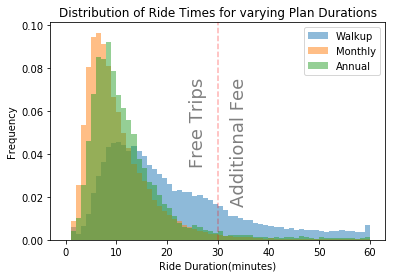

In [33]:
"""
I am first grouping data by the Plan Duration (0, 30, 365), and then grabbing each's minute data. the.hist() method counts the frequency
of each value per minute in the bins. Bins run from 0 to 60 minutes.
"""

histogram = data.groupby('Plan Duration')['minutes'].plot.hist(bins = np.arange(61), alpha=0.5, normed=True)
plt.legend(['Walkup', 'Monthly', 'Annual'])
plt.text(36, 0.05, "Free Trips\n\nAdditional Fee", ha='right',
         size=18, rotation=90, alpha=0.5, color='black')
plt.axvline(30, linestyle='--', color='red', alpha=0.3);

plt.xlabel('Ride Duration(minutes)')
plt.title('Distribution of Ride Times for varying Plan Durations')

In [34]:
"""
Mean number of people that use each Pass
"""

output = data.groupby(['Passholder Type'])['minutes'].mean()
output

Passholder Type
Flex Pass       19.853105
Monthly Pass    14.324154
Staff Annual    45.112565
Walk-up         50.018096
Name: minutes, dtype: float64

In [ ]:
!pip install geopy

In [35]:
"""
This function finds the starting station with the highest number of trips and how many trips
"""

frequency_stations = data.pivot_table(index = ['Starting Station ID'],values = 'Trip ID', aggfunc = 'count')
m = frequency_stations.idxmax()
val = frequency_stations.max()
print('Starting Station ID', 'Frequency')
print(m,val)

Starting Station ID Frequency
Trip ID    3069.0
dtype: float64 Trip ID    5138
dtype: int64


In [36]:
"""
This function finds the ending station with the highest number of trips and how many trips
"""

frequency_stations = data.pivot_table(index = ['Ending Station ID'],values = 'Trip ID', aggfunc = 'count')
m = frequency_stations.idxmax()
val = frequency_stations.max()
print('Ending Station ID', 'Frequency')
print(m,val)

Ending Station ID Frequency
Trip ID    3005.0
dtype: float64 Trip ID    6262
dtype: int64


In [37]:
"""
Constructing a new matrix with all row indeces, whose columns are the Starting Station lat/long and Ending Station lat/long
"""

new_data = data[['Starting Station Latitude', 'Starting Station Longitude',
      'Ending Station Latitude', 'Ending Station Longitude']]

In [38]:
"""
If any column value is null or NaN, thenn it is replaced with -1
"""

new_data[new_data.isnull().values] = -1

/home/sachk/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/sachk/.local/lib/python3.6/site-packages/pandas/core/frame.py:3163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)


In [39]:
"""
Just to check make sure any null values are replaced
"""

new_data.isnull().values.any()

False

In [41]:
def distance_func(row):
    data = []
    flag = False
    for i in range(0, 2):
        string = ''
        if(i == 0):
            string = 'Starting '
        else:
            string = 'Ending '
        lat = row[string + 'Station Latitude']
        long = row[string + 'Station Longitude']
        if( (lat != -1 and lat != 0) and (lat != -1 and lat != 0) ):
            splitted = string.split(',')
            data.append((lat, long))
        else:
            flag = True
            break
    if(flag):
        return -1
    else:
        return distance.distance(data[0], data[1]).miles

# A helper function that finds the distance between the starting and ending stations
distance_func(data.iloc[3])

0.0

In [42]:
data['distance'] = new_data.apply(distance_func, axis = 1)

In [44]:
#Mean distance metric

data['distance'].mean()

0.6481394196315198

/home/sachk/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


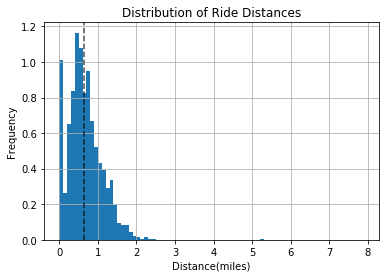

In [45]:
"""
Plotting the distribution of distances from 0 to 8 miles
"""

data['distance'].hist(bins = np.arange(0, 8, 0.1), normed = True)
plt.xlabel('Distance(miles)')
plt.ylabel('Frequency')
plt.title('Distribution of Ride Distances')
plt.axvline(data['distance'].mean(), linestyle='--', color='black', alpha=0.7);

Text(0, 0.5, 'Number of Trips')

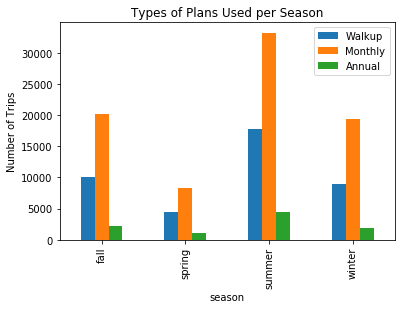

In [46]:
"""
PLotting the distribution of trip frequency for plans across seasons
"""

data.pivot_table(index = 'season', columns = 'Plan Duration', values = 'Trip ID', aggfunc = 'count').plot.bar(title = 'Types of Plans Used per Season')
plt.legend(['Walkup', 'Monthly', 'Annual'])
plt.ylabel('Number of Trips')

In [47]:
seasonal_plans = data.pivot_table(index = 'season', columns = 'Plan Duration', values = 'Trip ID', aggfunc = 'count').fillna(0)
print('Mean Seasonal Counts over Plans')
print('Walkup  :',seasonal_plans[0.0].mean())
print('Monthly :', seasonal_plans[30.0].mean())
print('Annual  :', seasonal_plans[365.0].mean())

Mean Seasonal Counts over Plans
Walkup  : 10306.0
Monthly : 20230.0
Annual  : 2379.25


In [48]:
"""
Mean plan duration over all seasons
"""

data.groupby('season')['minutes'].mean()

season
fall      25.338949
spring    30.016180
summer    23.945291
winter    28.270521
Name: minutes, dtype: float64

/home/sachk/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


season
fall      AxesSubplot(0.125,0.125;0.775x0.755)
spring    AxesSubplot(0.125,0.125;0.775x0.755)
summer    AxesSubplot(0.125,0.125;0.775x0.755)
winter    AxesSubplot(0.125,0.125;0.775x0.755)
Name: minutes, dtype: object


Text(0, 0.5, 'Frequency')

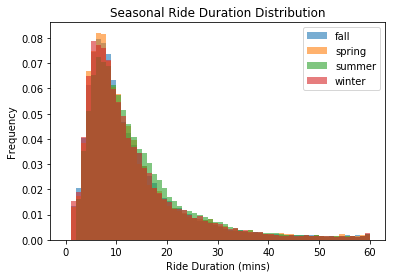

In [50]:
#Histogram of the frequency of ride durations across all seasons
histogram = data.groupby('season')['minutes'].hist(bins = np.arange(61), alpha=0.6, normed=True, grid = False)
print(histogram)
plt.legend(['fall', 'spring', 'summer', 'winter'])
plt.title('Seasonal Ride Duration Distribution')
plt.xlabel('Ride Duration (mins)')
plt.ylabel('Frequency')

In [51]:
#Adding a speed column to the dataframe which takes distance by minutes

data['speed'] = 60*data['distance']/data['minutes']
data['speed'].max()

40.61715762946486

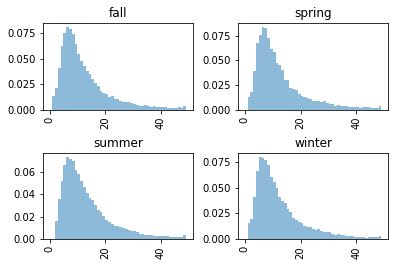

In [52]:
#PLot seasonal distribution of ride distributions on separate plots, because all have the same distribution

fig, ax = plt.subplots(2,2)
fig.subplots_adjust(wspace=0.4)
histogram = data.hist(bins = np.arange(50),by = 'season', column = 'minutes', alpha=0.5, density=True, grid = False, ax = ax)

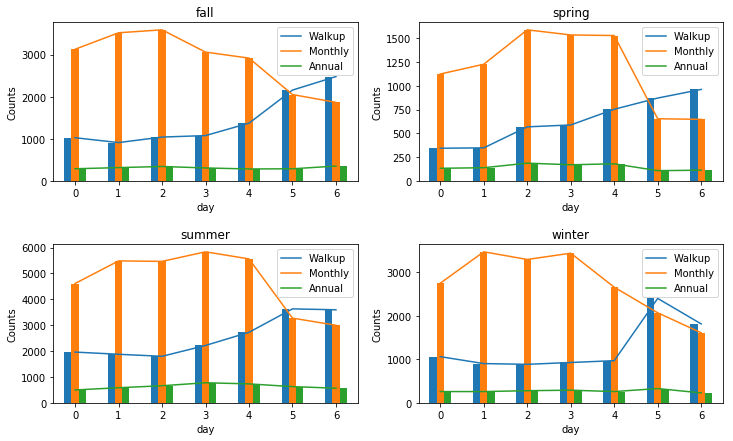

In [53]:
"""
Plot of plan frequnecy across all seasons. The lines are just the peaks of the bars
"""


fig, ax = plt.subplots(2,2, figsize = (12,7))
fig.subplots_adjust(hspace=0.4)
season_durations = data.pivot_table(index = ['season', 'Plan Duration'], columns = 'day', values = 'Trip ID', aggfunc = 'count')
season_durations.loc['fall'].T.plot.bar(ax = ax[0][0], title = 'fall')
season_durations.loc['fall'].T.plot(ax = ax[0][0])
season_durations.loc['spring'].T.plot.bar(ax = ax[0][1], title = 'spring')
season_durations.loc['spring'].T.plot(ax = ax[0][1])
season_durations.loc['summer'].T.plot.bar(ax = ax[1][0], title = 'summer')
season_durations.loc['summer'].T.plot(ax = ax[1][0])
season_durations.loc['winter'].T.plot.bar(ax= ax[1][1], title = 'winter')
season_durations.loc['winter'].T.plot(ax = ax[1][1])

for a in ax:
    for b in a:
        b.legend(['Walkup', 'Monthly', 'Annual'])
        b.set_ylabel('Counts')

/home/sachk/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


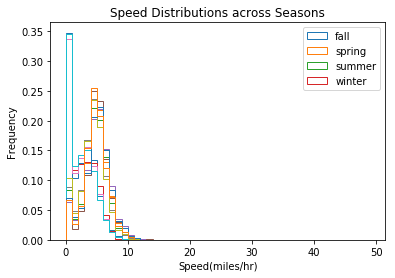

In [54]:
"""
Speed Distributions across all Seasons for different Plan holders. histtype is step chosen because all distributions are the same
shape
"""

data.groupby(by = ['season', 'Plan Duration'])['speed'].plot.hist(bins = np.arange(0, 50), histtype = 'step', normed = True)
plt.title('Speed Distributions across Seasons')
plt.xlabel('Speed(miles/hr)')
plt.legend(['fall', 'spring', 'summer','winter'])

In [55]:
#Passholder Type and Trip Route Category Correlation Matrix

data.pivot_table(index = 'Trip Route Category', columns = 'Passholder Type', values = 'Trip ID', aggfunc = 'count')

Passholder Type,Flex Pass,Monthly Pass,Staff Annual,Walk-up
Trip Route Category,,,,
One Way,9034,77532,299,32777
Round Trip,483,3772,83,8447


Text(0.5, 1.0, 'Distribution of Routes across Different Pass Holders')

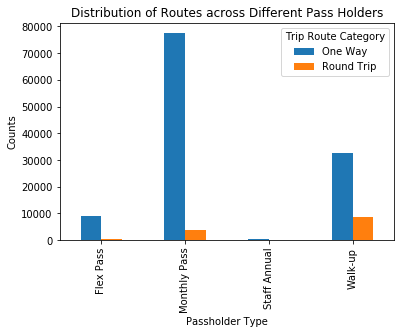

In [56]:
#A PLot of the table above

data.pivot_table(index = 'Trip Route Category', columns = 'Passholder Type', values = 'Trip ID', aggfunc = 'count').T.plot.bar()
plt.ylabel('Counts')
plt.title('Distribution of Routes across Different Pass Holders')

In [57]:
#I am trying to create a new dataframe whose row index are hours in the day, and the columns represent the corresponding max count
#the most popular starting and ending stations
print(data.pivot_table(index = 'hour', columns = 'Starting Station ID', values = 'Trip ID', aggfunc = 'count').fillna(0).max(axis = 1))
print(data.pivot_table(index = 'hour', columns = 'Starting Station ID', values = 'Trip ID', aggfunc = 'count').fillna(0).idxmax(axis = 1))
df = pd.DataFrame(data = {'maxvals_start': data.pivot_table(index = 'hour', columns = 'Starting Station ID', values = 'Trip ID', aggfunc = 'count').fillna(0).max(axis = 1),
                                 'indeces_start': data.pivot_table(index = 'hour', columns = 'Starting Station ID', values = 'Trip ID', aggfunc = 'count').fillna(0).idxmax(axis = 1),
                               'maxvals_end': data.pivot_table(index = 'hour', columns = 'Ending Station ID', values = 'Trip ID', aggfunc = 'count').fillna(0).max(axis = 1),
                                'indeces_end': data.pivot_table(index = 'hour', columns = 'Ending Station ID', values = 'Trip ID', aggfunc = 'count').fillna(0).idxmax(axis = 1)
                               })

hour
0     101.0
1      87.0
2      83.0
3      73.0
4     146.0
5      47.0
6     335.0
7     612.0
8     573.0
9     359.0
10    253.0
11    411.0
12    531.0
13    548.0
14    481.0
15    372.0
16    736.0
17    650.0
18    576.0
19    510.0
20    324.0
21    224.0
22    204.0
23    177.0
dtype: float64
hour
0     3008.0
1     3082.0
2     3005.0
3     3005.0
4     3047.0
5     3067.0
6     3014.0
7     3014.0
8     3014.0
9     3034.0
10    3031.0
11    3030.0
12    3030.0
13    3069.0
14    3069.0
15    3069.0
16    3030.0
17    3030.0
18    3005.0
19    3005.0
20    3005.0
21    3064.0
22    3022.0
23    3022.0
dtype: float64


In [ ]:
df

In [61]:
#Frequency of starting stations in the morning and evening

print('Morning', df.iloc[0:12]['indeces_start'].value_counts())
print('Evening', df.iloc[12:24]['indeces_start'].value_counts())

Morning 3014.0    3
3005.0    2
3030.0    1
3031.0    1
3034.0    1
3067.0    1
3047.0    1
3082.0    1
3008.0    1
Name: indeces_start, dtype: int64
Evening 3005.0    3
3069.0    3
3030.0    3
3022.0    2
3064.0    1
Name: indeces_start, dtype: int64


In [62]:
#printing the most popular starting stations and their associated counts in the morning
print('Morning Start Indeces')
for i in df.iloc[0:12]['indeces_start'].value_counts().index.values:
    print(str(i) + "      " + str(df.iloc[0:12]['indeces_start'].value_counts().loc[i]*( sum(  df['maxvals_start'].loc[np.where(df['indeces_start'] == i)].values) ) ) )
    
#printing the most popular starting stations and their associated counts in the evening
print('Evening Start Indeces')
for i in df.iloc[12:24]['indeces_start'].value_counts().index.values:
    print(str(i) + "      " + str(df.iloc[12:24]['indeces_start'].value_counts().loc[i]*( sum(  df['maxvals_start'].loc[np.where(df['indeces_start'] == i)].values) ) ) )

Morning Start Indeces
3014.0      4560.0
3005.0      3132.0
3030.0      2328.0
3031.0      253.0
3034.0      359.0
3067.0      47.0
3047.0      146.0
3082.0      87.0
3008.0      101.0
Evening Start Indeces
3005.0      4698.0
3069.0      4203.0
3030.0      6984.0
3022.0      762.0
3064.0      224.0


In [63]:
#printing the most popular ending stations and their associated counts in the evening
print('Morning End Indeces')
for i in df.iloc[0:12]['indeces_end'].value_counts().index.values:
    print(str(i) + "      " + str(df.iloc[0:12]['indeces_end'].value_counts().loc[i]*( sum(  df['maxvals_end'].loc[np.where(df['indeces_end'] == i)].values) ) ) )
    
#printing the most popular ending stations and their associated counts in the evening
print('Evening End Indeces')
for i in df.iloc[12:24]['indeces_end'].value_counts().index.values:
    print(str(i) + "      " + str(df.iloc[12:24]['indeces_end'].value_counts().loc[i]*( sum(  df['maxvals_end'].loc[np.where(df['indeces_end'] == i)].values) ) ) )

Morning End Indeces
3005.0      8020.0
3031.0      9420.0
3069.0      3462.0
3019.0      165.0
3008.0      74.0
Evening End Indeces
3031.0      11775.0
3014.0      2814.0
3069.0      3462.0
3038.0      273.0
3042.0      1079.0
3022.0      412.0


In [59]:
#Frequnecy of starting stations in the morning and afternoon

print('Morning', df.iloc[0:12]['indeces_end'].value_counts())
print('Afternoon', df.iloc[12:24]['indeces_end'].value_counts())

Morning 3005.0    4
3031.0    4
3069.0    2
3019.0    1
3008.0    1
Name: indeces_end, dtype: int64
Afternoon 3031.0    5
3014.0    2
3069.0    2
3038.0    1
3042.0    1
3022.0    1
Name: indeces_end, dtype: int64
